<a name='top'></a>Contents
===
- [Introduction](#intro)

- [Libraries](#libraries)

- [Functions](#functions)

- [Settings](#settings)

- [Dataset](#dataset)
      
- [Exploratory data analysis](#exploratory)
    - [Numerical and Categorical data features](#exploratory_features)
    - [Missing values](#exploratory_missing)
    - [Describe Numerical Data](#exploratory_describe_numerical)
    - [Describe Categorical Data](#exploratory_describe_categorical)
    - [Distribution of Target Variable](#distribution_target)
    - [Distribution of logarithm target variable](#distribution_target_log)
    - [Target distribution by categorical values](#distribution_target_categorical)
        - [Target distribution by cat_price](#distribution_target_catprice)
        - [Target distribution by CatN1](#distribution_target_catn1)
    - [Distribution of numerical features](#distribution_columns)
        - [Skewness and kurtosis of numerical features](#skewness_columns)
        - [Logarithm to numerical features](#logarithm_columns)
    - [Distribution of numerical features with target variable](#relation_numerical_columns)
    - [Distribution of categorical features with target variable](#relation_categorical_columns)
    
    
- [Data wrangling](#data_wrangling)
    - [Correlation](#data_correlation)
        - [Correlation of numerical features to target variable](#data_correlation_numerical_original)
        - [Correlation of categorical features to target variable](#data_correlation_categorical_original)
    - [Feature Selection](#data_feature_selection)
        - [Pearson](#data_pearson)
        - [Random Forest](#data_random_forest)    
        - [LGBMRegressor](#data_LGBMRegressor)
        - [Final Feature Selection](#data_final_feature_selection)
    - [Outliers](#outliers)
    - [Correlation feature selection](#correlation_feature_selection)
    - [Distribution of feature selection with target](#distribution_feature_selection)
    - [Multicollinearity](#multicollinearity)
    - [StandardScaler](#standardscaler)
    - [Grade Percentile of target variable](#grade_percentile_target)
    - [Correlation and Distribution final dataset](#distribution_final_dataset)
    

- [Regression Models](#regression_models)
    - [Data for models](#data_models)
    - [Model application](#application_models)   
        - [KNeighbors Regressor](#knn)
        - [Linear Regression](#mlr)
        - [Ridge](#ridge)
        - [Lasso](#lasso)
        - [Elastic Net](#enet)
        - [SGD Regressor](#sgd)
        - [Decision Tree Regressor](#dtr)
        - [Gradient Boosting Regressor](#gbr)
        - [Random Forest Regressor](#rfr)
    - [Regression Models Results](#comparison)
    - [Feature importance](#feature_importance)



------------------------------------------------------------------------------------------------------
<a name='intro'></a>
# Introduction

This document includes three important steps to develop a regression model from the database in order to obtain the main factors that affect the optimization of google shopping campaigns.

These main steps are:
    * Exploratory data analysis
    * Data wrangling
    * Regression Models

-----------------------------------------------------------------------------------
<a name='libraries'></a>
# Libraries

First of all, it is necessary to import the required libraries to develop all the steps correctly of this notebook.

In [1]:
#import standard libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from scipy import stats
%matplotlib inline
sns.set()


#import libraries for data wrangling
import math
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


#import model libraries
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor



#import filter warnings
import warnings
warnings.filterwarnings('ignore')


#display a maximum of 500 columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#set directory of work
path = '/home/miguel/my_project_python/my_project_env/tfm/shopping'
os.chdir(path)

-----------------------------------------------------------------------------------------------
<a name='functions'></a>
# Functions
In this chapter is run the functions used in this notebook.

In [3]:
#print categorical columns
def columns_categorical(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print('\nColumn Name:', col,)
            print(df[col].value_counts())
            
            
            
#correlation heatmap
def plot_correlation_heatmap(df, number_columns, arg):
    
    #calculate correlation
    corr = df.corr()
    corr_abs = corr.abs()
    columns = corr_abs.nlargest(number_columns, arg)[arg].index
    cont = np.corrcoef(df[columns].values.T)

    #plot values
    plt.figure(figsize = (number_columns, number_columns))
    sns.set(font_scale = 1.5)
    sns.heatmap(cont, linewidths=1.5, annot=True, square=True, fmt='.2f', 
                annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    
    #show
    plt.show()
    

#pearson selector
def pearson_selector(feature_name, X, y):
    
    #create empty dataframe
    correlation_list = []
    
    #calculate the correlation for for each feature with target variable
    for i in feature_name:
        corr = np.corrcoef(X[i], y)[0, 1]
        correlation_list.append(corr)
        
    #fillna nan values with 0
    correlation_list = [0 if np.isnan(i) else i for i in correlation_list]
    
    #feature correlation
    corr_feature = X.iloc[:,np.argsort(np.abs(correlation_list))[-20:]].columns.tolist()
    
    #asign value
    corr_support = [True if i in corr_feature else False for i in feature_name]
    
    return corr_support, corr_feature


#prove: assing value to column name
def prove(df, col):
    if df[col] == 'Clics':
        df['NEW'] = 'Clic_Imp_CTR'
    elif df[col] == 'Impressions':
        df['NEW'] = 'Clic_Imp_CTR'
    elif df[col] == 'CTR':
        df['NEW'] = 'Clic_Imp_CTR'
    elif df[col] == 'Page':
        df['NEW'] = 'Clic_Imp_CTR'
    elif df[col] == 'CPC':
        df['NEW'] = 'Clic_Imp_CTR'
        
    elif df[col] == 'CatN1':
        df['NEW'] = 'CatN'
    elif df[col] == 'CatN2':
        df['NEW'] = 'CatN'
        
    elif df[col] == 'Cost':
        df['NEW'] = 'Cost_Inc'
    elif df[col] == 'Net':
        df['NEW'] = 'Cost_Inc'
    elif df[col] == 'Ads':
        df['NEW'] = 'Cost_Inc'
        
    elif df[col] == 'Conversions':
        df['NEW'] = 'Conversions'
    elif df[col] == 'All':
        df['NEW'] = 'Conversions'
        
    elif df[col] == 'Cat':
        df['NEW'] = 'Cat_Price'
    elif df[col] == 'Units':
        df['NEW'] = 'Units_Sold'
    else:
        df['NEW'] = 'ROAS'        
                
    return df['NEW']

-----------------------------------------------------------------------------------------------
<a name='settings'></a>
# Settings

It is established the fixed parameters which will be developed in the notebooK.

In [4]:
#set kurtosis and swekness values
kurt = 2
sw = 2

# set number of cross validations
nr_cv = 5

#number estimators
nr_est = 20

-----------------------------------------------------------------------------------------------
<a name='dataset'></a>
# Dataset

It is opened the dataset of study.

In [5]:
#open the dataset of study
df = pd.read_pickle('./data/final/data_final_ROAS_ADS.pkl')

Check the data

In [6]:
df.head()

,CatN1,CatN2,Cat_Price,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads
136,muebles,"consolas, recibidores y tocadores",200.0,0.26,0.06,0.03,0.02,0.02,39.0,36.71,18.93,12.62,9.46,4.0,0.86,0.43,0.29,0.21,0.102564,0.03,0.02,0.02,0.02,37.0,21.29,21.29,17.71,13.61,1.03,0.20,0.10,0.07,0.05,0.16,0.02,0.01,0.01,0.01,0.16,0.02,0.01,0.01,0.01,24.78,3.54,1.77,1.18,0.88,24.78,3.54,1.77,1.18,0.88,0.0,83.10,115.19,84.58,69.28,0.0,0.57,0.79,0.57,0.46,24.06
172,muebles,"consolas, recibidores y tocadores",200.0,0.26,0.36,0.34,0.34,0.31,451.0,278.00,280.79,235.86,206.50,3.0,1.43,1.79,1.67,1.54,0.006652,0.01,0.01,0.01,0.01,9.0,21.29,16.64,15.95,16.61,0.78,0.61,0.65,0.60,0.52,0.31,0.04,0.02,0.01,0.01,0.31,0.04,0.02,0.01,0.01,62.02,8.86,4.43,2.95,2.22,62.02,8.86,4.43,2.95,2.22,0.0,39.74,50.26,33.51,25.13,0.0,0.29,0.36,0.24,0.18,79.51
186,muebles,"consolas, recibidores y tocadores",200.0,0.30,0.46,0.42,0.41,0.41,824.0,739.00,631.86,500.62,454.07,7.0,5.00,5.14,4.14,3.64,0.008495,0.01,0.01,0.01,0.01,19.0,20.00,16.00,14.19,14.64,2.08,2.30,2.21,1.78,1.59,1.00,0.14,0.07,0.06,0.08,1.00,0.14,0.07,0.06,0.08,277.00,39.57,19.79,14.75,18.64,277.00,39.57,19.79,16.11,19.65,0.0,19.13,33.54,32.93,29.00,0.0,0.14,0.29,0.29,0.25,133.17
203,muebles,"consolas, recibidores y tocadores",200.0,0.39,0.33,0.32,0.37,0.39,1275.0,1144.86,1181.00,1043.95,963.54,6.0,5.57,8.71,7.90,7.36,0.004706,0.00,0.01,0.01,0.01,19.0,11.86,8.57,11.05,12.93,2.34,1.83,3.32,3.20,3.01,0.33,0.05,0.02,0.06,0.05,0.33,0.05,0.02,0.06,0.05,4.97,0.71,0.36,13.43,10.07,4.97,0.71,0.36,13.43,10.07,0.0,0.00,10.51,13.38,10.04,0.0,0.00,0.07,0.10,0.07,2.12
29,muebles,"consolas, recibidores y tocadores",200.0,0.29,0.26,0.26,0.27,0.27,3186.0,3512.00,3512.00,3512.00,3512.00,12.0,14.50,14.50,14.50,14.50,0.003766,0.00,0.00,0.00,0.00,9.0,18.50,18.50,18.50,18.50,3.50,3.95,3.95,3.95,3.95,0.33,0.16,0.16,0.16,0.16,0.33,0.66,0.66,0.66,0.66,58.81,29.40,29.40,29.40,29.40,58.81,29.40,29.40,29.40,29.40,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,16.80


In [7]:
df.shape

(494, 64)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 136 to 204
Data columns (total 64 columns):
CatN1                 494 non-null object
CatN2                 494 non-null object
Cat_Price             494 non-null object
CPC_medio             494 non-null float64
CPC_medio_1w          494 non-null float64
CPC_medio_2w          494 non-null float64
CPC_medio_3w          494 non-null float64
CPC_medio_4w          494 non-null float64
Impressions           494 non-null float64
Impressions_1w        494 non-null float64
Impressions_2w        494 non-null float64
Impressions_3w        494 non-null float64
Impressions_4w        494 non-null float64
Clics                 494 non-null float64
Clics_1w              494 non-null float64
Clics_2w              494 non-null float64
Clics_3w              494 non-null float64
Clics_4w              494 non-null float64
CTR                   494 non-null float64
CTR_1w                494 non-null float64
CTR_2w                494 non-null f

-----------------------------------------------------------------------
<a name='exploratory'></a>
# Exploratory data analysis

In this chapter, it is analyzed the data imported: numerical and categorical features, features distribution, missing values, etc.


<a name='exploratory_features'></a>
## Numerical and Categorical data features

¿How many does numerical and categorical columns contain the dataset?


In [9]:
#number of numerical columns features
numerical_columns = df.dtypes[df.dtypes != 'object'].index
print('Number of NUMERICAL COLUMNS: {} '.format(len(numerical_columns)))

#number of categorical columns features
categorical_columns = df.dtypes[df.dtypes == 'object'].index
print('Number of CATEGORICAL COLUMNS: {} '.format(len(categorical_columns)))

Number of NUMERICAL COLUMNS: 61 
Number of CATEGORICAL COLUMNS: 3 


In [10]:
#names of numerical and categorical columns
print('Numerical columns: {} '.format(df[numerical_columns].columns))
print('-'*228)
print('Categorical columns: {} '.format(df[categorical_columns].columns))

Numerical columns: Index(['CPC_medio', 'CPC_medio_1w', 'CPC_medio_2w', 'CPC_medio_3w',
       'CPC_medio_4w', 'Impressions', 'Impressions_1w', 'Impressions_2w',
       'Impressions_3w', 'Impressions_4w', 'Clics', 'Clics_1w', 'Clics_2w',
       'Clics_3w', 'Clics_4w', 'CTR', 'CTR_1w', 'CTR_2w', 'CTR_3w', 'CTR_4w',
       'Page_Views', 'Page_Views_1w', 'Page_Views_2w', 'Page_Views_3w',
       'Page_Views_4w', 'Cost', 'Cost_1w', 'Cost_2w', 'Cost_3w', 'Cost_4w',
       'Conversions', 'Conversions_1w', 'Conversions_2w', 'Conversions_3w',
       'Conversions_4w', 'All_Conversions', 'All_Conversions_1w',
       'All_Conversions_2w', 'All_Conversions_3w', 'All_Conversions_4w',
       'Ads_Income', 'Ads_Income_1w', 'Ads_Income_2w', 'Ads_Income_3w',
       'Ads_Income_4w', 'Ads_Income_All', 'Ads_Income_All_1w',
       'Ads_Income_All_2w', 'Ads_Income_All_3w', 'Ads_Income_All_4w',
       'Net_Incomes', 'Net_Incomes_1w', 'Net_Incomes_2w', 'Net_Incomes_3w',
       'Net_Incomes_4w', 'Units_sold', 'U

<a name='exploratory_missing'></a>
## Missing values

It is checked if there are missing values in the dataset.

In [11]:
print('Missing values in the dataset: {} '.format(df.isnull().sum().sum()))

Missing values in the dataset: 0 


<a name='exploratory_describe_numerical'></a>
## Describe Numerical Data

Describe the data: count, mean, IQR, etc.


In [12]:
df.describe()

,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,0.270364,0.252085,0.241619,0.237065,0.231579,2557.172065,2358.982510,2220.139190,2158.227166,2105.784676,31.973684,28.533806,26.760223,25.817773,24.929291,0.013689,0.013441,0.013340,0.013178,0.012955,43.900810,38.059858,35.716336,34.462713,33.222368,8.191538,7.024069,6.501215,6.265769,6.056660,0.849372,0.316619,0.270911,0.252470,0.233927,1.803988,0.837510,0.766134,0.738968,0.702206,66.261903,20.953846,16.906619,15.415951,14.280911,111.887652,35.724899,27.937794,24.846741,22.419109,39.107004,22.466296,19.930830,18.582389,17.639413,0.951417,0.579231,0.515466,0.485101,0.456943,18.858583
std,0.104756,0.088342,0.085563,0.087765,0.090071,1972.006207,1813.722042,1751.061202,1737.612110,1739.487238,27.291405,23.767561,22.408686,21.777151,21.323389,0.008090,0.005829,0.005402,0.005235,0.005032,37.628701,29.068457,26.833517,25.593281,25.069988,7.305565,5.939428,5.331901,5.120840,4.991351,0.605940,0.272693,0.246635,0.236982,0.226736,1.312097,0.777668,0.741878,0.729667,0.722755,74.279395,18.406402,14.291642,12.968901,12.560410,139.301282,34.569054,24.492646,20.415149,18.527260,59.035413,23.077775,17.532689,15.023434,13.524284,1.227503,0.651504,0.552167,0.507737,0.462568,45.666420
min,0.040000,0.040000,0.030000,0.020000,0.010000,39.000000,36.710000,18.930000,12.620000,9.460000,1.000000,0.860000,0.430000,0.290000,0.210000,0.001515,0.000000,0.000000,0.000000,0.000000,9.000000,1.290000,0.640000,0.430000,0.430000,0.080000,0.160000,0.100000,0.070000,0.050000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.010000,0.010000,0.450000,0.060000,0.030000,0.020000,0.020000,0.450000,0.060000,0.030000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000
25%,0.200000,0.190000,0.190000,0.180000,0.180000,1192.000000,1092.465000,940.907500,914.992500,912.280000,13.000000,10.860000,10.195000,9.452500,9.245000,0.008349,0.010000,0.010000,0.010000,0.010000,19.000000,17.325000,17.290000,16.502500,15.960000,3.030000,2.700000,2.452500,2.432500,2.350000,0.392500,0.140000,0.080000,0.070000,0.070000,1.000000,0.290000,0.252500,0.230000,0.200000,21.502500,7.700000,6.650000,5.587500,5.442500,30.362500,12.930000,10.345000,9.305000,9.072500,0.000000,6.360000,7.332500,7.080000,7.467500,0.000000,0.140000,0.140000,0.140000,0.140000,3.187500
50%,0.260000,0.250000,0.240000,0.240000,0.240000,2043.000000,1950.355000,1774.285000,1637.785000,1563.555000,24.000000,21.000000,20.325000,19.455000,18.945000,0.012020,0.010000,0.010000,0.010000,0.010000,28.000000,29.43

<a name='exploratory_describe_categorical'></a>
## Describe Categorical Data

It is showed the values of categorical data and theirs frecuency.


In [13]:
#show values of categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        print('\nColumn Name: {}'.format(column))
        print('{}'.format(df[column].value_counts()))


Column Name: CatN1
muebles                          191
decoración para tu casa          166
organización y almacenamiento     56
decoración de navidad             19
textil hogar                      16
baño                              13
playa y camping                   10
cocina y comedor                   9
lámparas e iluminación             8
jardín y terraza                   6
Name: CatN1, dtype: int64

Column Name: CatN2
espejos de pie y vestidores              83
espejos de pared                         70
consolas, recibidores y tocadores        63
percheros                                56
mesitas de noche                         32
sillas                                   27
mesas de centro y auxiliares             25
cómodas                                  20
belenes y portales de navidad            19
estanterías y librerías                  18
alfombras de bambú                       16
biombos separadores                      12
cenadores y gazebos plegables       

<a name='distribution_target'></a>
## Distribution of target variable

It is studied the distribution of the target variable: 'ROAS'

In [14]:
#set target variable
y = df['ROAS_Ads']

#describe target
y.describe()

count    494.000000
mean      18.858583
std       45.666420
min        0.040000
25%        3.187500
50%        7.230000
75%       17.950000
max      659.170000
Name: ROAS_Ads, dtype: float64

Plot the distribution and display its skewness and kurtosis

Skewness: 8.4
Kurtosis: 94.88


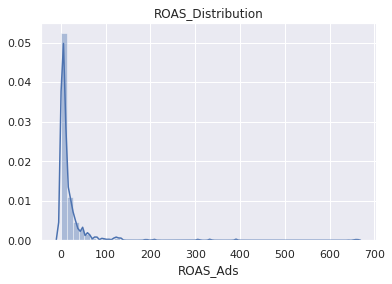

In [19]:
#target distribution
x = sns.distplot(y).set_title('ROAS_Distribution');


#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

#save fig
x.figure.savefig('./img/ROAS_Distribution.png', dpi = 180)

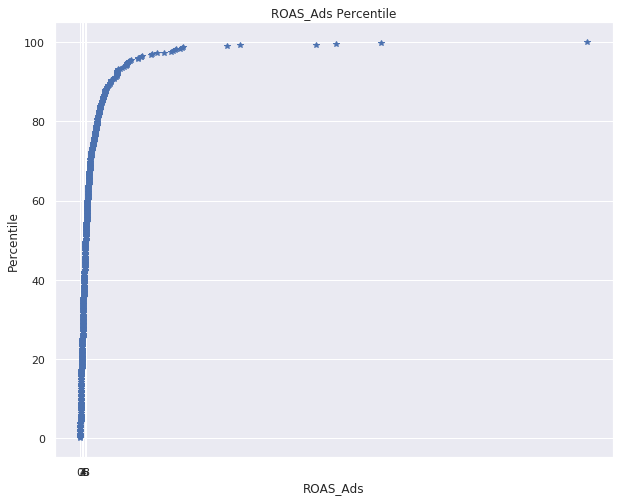

In [20]:
#create percentile
df['percentile'] = df['ROAS_Ads'].apply(lambda x: percentileofscore(df['ROAS_Ads'], x))

# plot percentile
#set size
x = plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['ROAS_Ads'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS_Ads')
plt.ylabel('Percentile')
plt.title('ROAS_Ads Percentile');

#save fig
x.savefig('./img/ROAS_Ads_Percentile.png', dpi = 180)

In [21]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'ROAS_Ads']),2)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'ROAS_Ads']),2)))

Score to achieve 50th percentile: 7.28
Score to achieve 90th percentile: 40.25


**¿How is the target variable distributed?**
<br>As we can see from the previous graphs, the target feature is not normally distributed. 
<br>Moreover, the values of Skewness and Kurtosis are not close to their recommendable value: 0 (these values should be near to 0 in order to achieve a normal distribution).

**¿How can affect to the regression models?**
<br>Most of machine learning models assumes the data is normally distributed and if it is not achieve this goal: the performance of the machine learning models cab be reduced dractically (for example: linear regression).

**¿How can it be solved?**
<br>It is necessary to apply log transformation to these variable.

<a name='distribution_target_log'></a>
## Distribution of logarithm target variable 
Then, it is applied logarithm neperian to the target variable

Skewness: -0.16
Kurtosis: 0.74


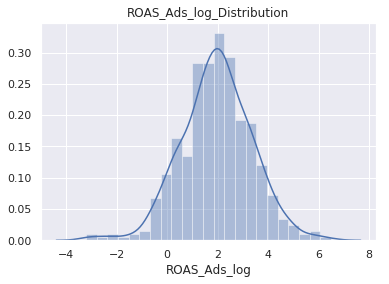

In [22]:
#create log target feature
df['ROAS_Ads_log'] = np.log(df['ROAS_Ads'])

#drop previous target from dataframe
df.drop('ROAS_Ads', axis= 1, inplace=True)

df['ROAS_Ads_log'] = df['ROAS_Ads_log'].replace([np.inf, -np.inf], np.nan)
df['ROAS_Ads_log'].fillna(0, inplace = True)

#set as new target
y = df['ROAS_Ads_log']

#target distribution
x = sns.distplot(y).set_title('ROAS_Ads_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

#save fig
x.figure.savefig('./img/ROAS_Ads_log_Distribution.png', dpi = 180)

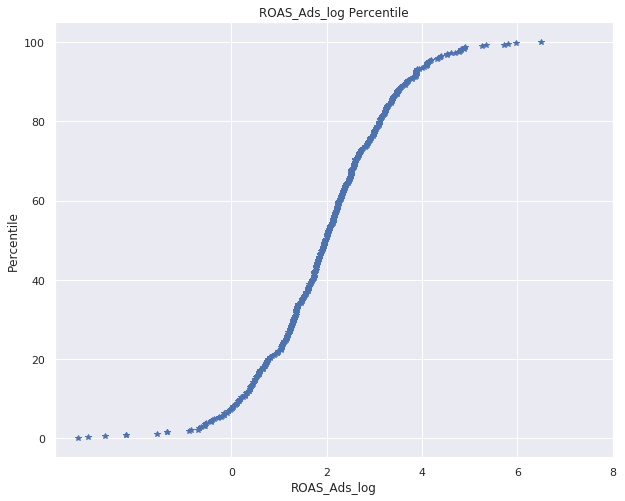

In [23]:
#create percentile
df['percentile'] = df['ROAS_Ads_log'].apply(lambda x: percentileofscore(df['ROAS_Ads_log'], x))

# plot percentile
#set size
x = plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['ROAS_Ads_log'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS_Ads_log')
plt.ylabel('Percentile')
plt.title('ROAS_Ads_log Percentile');

#save fig
x.savefig('./img/ROAS_Ads_log_Percentile.png', dpi = 180)

In [24]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'ROAS_Ads_log']),2)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'ROAS_Ads_log']),2)))

Score to achieve 50th percentile: 1.99
Score to achieve 90th percentile: 3.7


**¿How is the new target variable distributed?**
<br>As we can observe in the graph, the new target variable is almost close to a normal distribution with mean equal to 0.
<br>In addtion, the values of Skewness and Kurtosis are currently also closer to their recommended scores.



In [25]:
y.describe()

count    494.000000
mean       1.960826
std        1.398062
min       -3.218876
25%        1.159229
50%        1.978215
75%        2.887522
max        6.490981
Name: ROAS_Ads_log, dtype: float64

<a name='distribution_target_categorical'></a>
## Target distribution by categorical values

In this chapter, it is studied the distribution of the categorical features with the target variable.

<a name='distribution_target_catprice'></a>
### Target distribution by cat_price
Distribution of cat_price with ROAS_log.
<br> In this case it is necessary to apply this feature as categorical type.

In [26]:
#set as categorical
df['Cat_Price'] = pd.Categorical(df.Cat_Price,categories=["20.0", "30.0", "40.0", "50.0", "60.0", "80.0", 
                                                          "100.0", "150.0","200.0", "300.0"], ordered=True)

Plot the boxplot

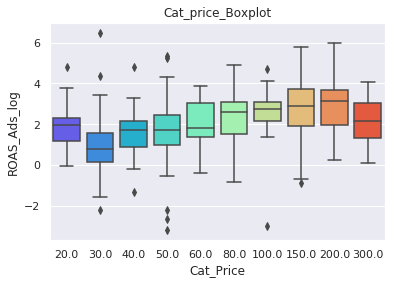

In [27]:
cat_sns1 = sns.boxplot(x='Cat_Price', y='ROAS_Ads_log', data=df, palette='rainbow').set_title('Cat_price_Boxplot')
cat_sns1.figure.savefig('./img/Cat_price_Boxplot.png', dpi = 180)

Plot the violin plot

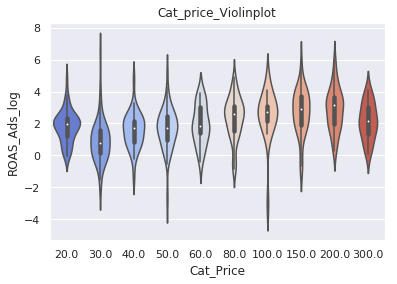

In [28]:
cat_sns2 = sns.violinplot(x='Cat_Price', y='ROAS_Ads_log', data=df, 
                          palette='coolwarm').set_title('Cat_price_Violinplot')
cat_sns2.figure.savefig('./img/Cat_price_Violinplot.png', dpi = 180)

As we can observe from these graphs, the distributions per category price are not perfectly normal, but they do not differ a lot from this type of distribution.

<a name='distribution_target_catn1'></a>
### Target distribution by CatN1
Distribution of category N1 with ROAS_log. 

Plot the boxplot

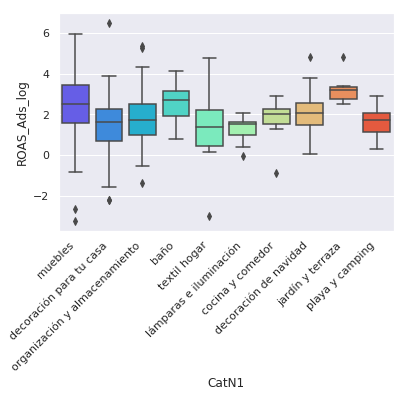

In [29]:
catN1_sns1 = sns.boxplot(x='CatN1', y='ROAS_Ads_log', data=df, palette='rainbow')
catN1_sns1.set_xticklabels(catN1_sns1.get_xticklabels(), rotation=45, ha='right')
catN1_sns1.figure.savefig('./img/Cat_N1_boxplot.png', dpi = 180)

Plot the violin plot

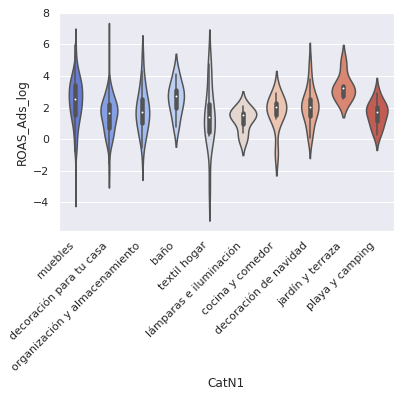

In [30]:
catN1_sns2 = sns.violinplot(x='CatN1', y='ROAS_Ads_log', data=df, palette='coolwarm')
catN1_sns2.set_xticklabels(catN1_sns2.get_xticklabels(), rotation=45, ha='right')
catN1_sns2.figure.savefig('./img/Cat_N1_violinplot.png', dpi = 180)

As in the previous case, the distributions are not normal.

<a name='distribution_columns'></a>
## Distribution of numerical features

In this chapter, it is analyzed the distribution of numerical features. 

<br> Moreover, it is considered the skewness and kurtosis in each case in order to apply logarithm if these scores exceeds atypical values.

**The upper limit score for skewness and kurtosis is 2 in both cases**, these values are considered acceptable in order to prove normal univariate distribution (George & Mallery, 2010; Gravetter & Wallnau, 2014).

<a name='skewness_columns'></a>
### Skewness and kurtosis of numerical features

Calculate the scores per numerical feature


In [31]:
#select index numerical columns
numerical_columns_index = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data = pd.DataFrame([])

for col in numerical_columns_index:
    data = data.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                     'Kurtosis': round(df[col].kurt(),2)}, 
                                    index=[0]), ignore_index=True)

Select categorical and object columns in order to create a dataframe

In [32]:
#filter numerical columns
numerical_columns_dist = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist = pd.DataFrame({'Index':numerical_columns_dist.index, 'Values':numerical_columns_dist.values})

Concatenate with skewness and kurtosis scores with their index of the previous list 

In [33]:
#concat both dataframes by index
df_concat = pd.concat([df_columns_dist['Index'], data], 1)

#show the values
df_concat

,Index,Skewness,Kurtosis
0,CPC_medio,0.78,1.44
1,CPC_medio_1w,0.32,0.72
2,CPC_medio_2w,-0.01,0.09
3,CPC_medio_3w,-0.04,-0.03
4,CPC_medio_4w,-0.15,-0.28
5,Impressions,1.55,3.31
6,Impressions_1w,1.50,2.62
7,Impressions_2w,1.49,2.47
8,Impressions_3w,1.46,2.09
9,Impressions_4w,1.48,1.97


Display a example

Skewness: 2.77
Kurtosis: 9.74


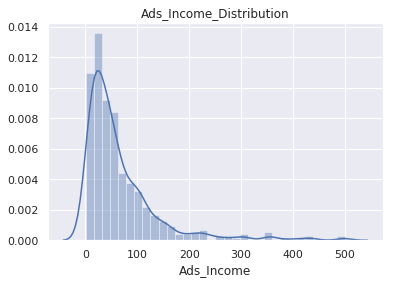

In [34]:
#plot distribution of Ads_Income
sns.distplot(df['Ads_Income']).set_title('Ads_Income_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Ads_Income'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Ads_Income'].kurt(),2)))

The "Ads_Income_Distribution" is not normal with mean 0. It shows a right-skewed (positive skewed) distribution.

Apply a filter for selecting features over fixed values of skewness and kurtosis

In [35]:
#filter columns that not accomplish the requirements
df_log = df_concat[(df_concat['Skewness']>=sw) | (df_concat['Kurtosis']>=kurt)]

#show the selection
df_log

,Index,Skewness,Kurtosis
5,Impressions,1.55,3.31
6,Impressions_1w,1.50,2.62
7,Impressions_2w,1.49,2.47
8,Impressions_3w,1.46,2.09
10,Clics,1.72,3.54
15,CTR,3.53,30.45
20,Page_Views,1.86,4.50
21,Page_Views_1w,1.49,2.00
22,Page_Views_2w,1.49,2.29
23,Page_Views_3w,1.50,2.46


In [36]:
print('{} features achieve the requirements score of skewness and kurtosis'.format(len(df_concat) - len(df_log)))

19 features achieve the requirements score of skewness and kurtosis


<a name='logarithm_columns'></a>
### Logarithm to numerical features

Then, it is necessary to apply logarithm to features that not accomplish the limit score

In [37]:
#apply string to index
lista = df_log['Index'].apply(str)

#create a list
c = lista.values.tolist()

#apply log to the list in order to create new columns and drop prevoius features
for col in c:
    df[col+'_log'] = np.log(df[col])
    df.drop([col], axis= 1, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 136 to 204
Data columns (total 65 columns):
CatN1                     494 non-null object
CatN2                     494 non-null object
Cat_Price                 494 non-null category
CPC_medio                 494 non-null float64
CPC_medio_1w              494 non-null float64
CPC_medio_2w              494 non-null float64
CPC_medio_3w              494 non-null float64
CPC_medio_4w              494 non-null float64
Impressions_4w            494 non-null float64
Clics_1w                  494 non-null float64
Clics_2w                  494 non-null float64
Clics_3w                  494 non-null float64
Clics_4w                  494 non-null float64
CTR_1w                    494 non-null float64
CTR_2w                    494 non-null float64
CTR_3w                    494 non-null float64
CTR_4w                    494 non-null float64
Cost_2w                   494 non-null float64
Cost_3w                   494 non-null float64
C

After applying logarithm to the selected columns, it is shown the new scores of skewness and kurtosis of all columns.

In [39]:
#select index numerical columns
numerical_columns_index_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data_log = pd.DataFrame([])

for col in numerical_columns_index_log:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col].fillna(0, inplace = True)
    data_log = data_log.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                             'Kurtosis': round(df[col].kurt(),2)}, 
                                            index=[0]), ignore_index=True)

#filter numerical columns
numerical_columns_dist_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist_log = pd.DataFrame({'Index':numerical_columns_dist_log.index, 
                                    'Values':numerical_columns_dist_log.values})    
    
#concat both dataframes by index
df_concat_log = pd.concat([df_columns_dist_log['Index'], data_log], 1)

#show the values
df_concat_log

,Index,Skewness,Kurtosis
0,CPC_medio,0.78,1.44
1,CPC_medio_1w,0.32,0.72
2,CPC_medio_2w,-0.01,0.09
3,CPC_medio_3w,-0.04,-0.03
4,CPC_medio_4w,-0.15,-0.28
5,Impressions_4w,1.48,1.97
6,Clics_1w,1.36,1.44
7,Clics_2w,1.38,1.56
8,Clics_3w,1.37,1.53
9,Clics_4w,1.42,1.73


Display again an example after that change

Skewness: -0.75
Kurtosis: 1.7


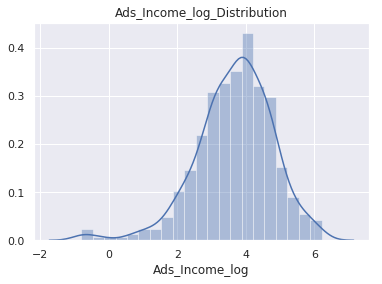

In [40]:
#plot distribution of ROAS_Ads_Ads
sns.distplot(df['Ads_Income_log']).set_title('Ads_Income_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Ads_Income_log'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Ads_Income_log'].kurt(),2)))

Now, the Ads_Income_log distribution is closer to a normal distribution.

<a name='relation_numerical_columns'></a>
## Distribution of numerical features with target variable

Show the distribution of the numerical features after applying logarithm to a selected group.


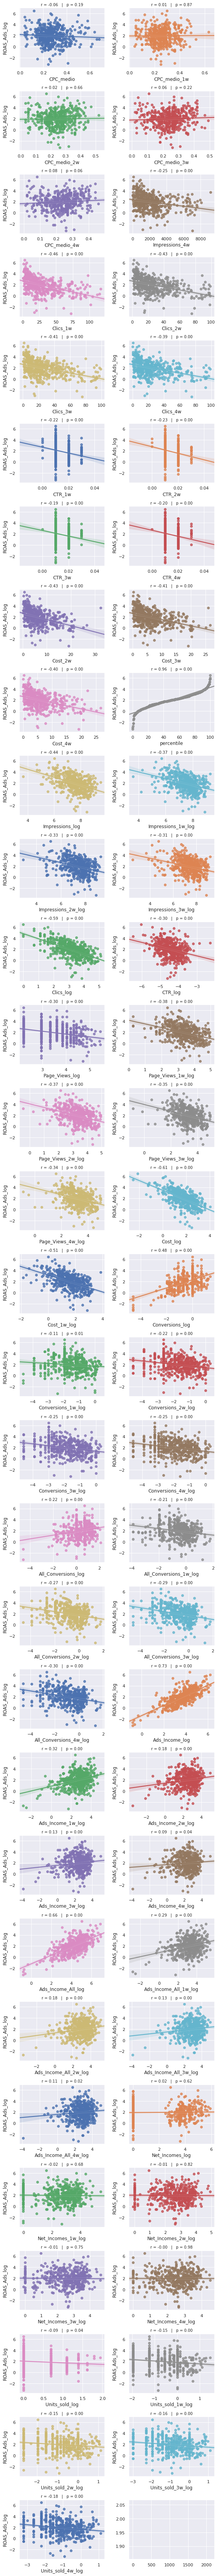

In [41]:
#number of rows and columns
number_rows = 31
number_cols = 2

#set target
y_df = 'ROAS_Ads_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_Ads_log', 'percentile_log']
li_plot_num_feats = [c for c in list(numerical_columns_index_log) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)

#show
plt.tight_layout()    
plt.show()

#save figure
fig.savefig('./img/distribution_numericalfeatures_with_target.png', dpi = 180)


As we can see, majority of these distributions have reduced their kurtosis ans skewness scores and they are almost normal distributions.

<a name='relation_categorical_columns'></a>
## Distribution of categorical features with target variable

In this chapter, it is analyzed the distribution of categorical features with target variable (previosly it was calculated for Cat_Price and CatN1, but not for CatN2)

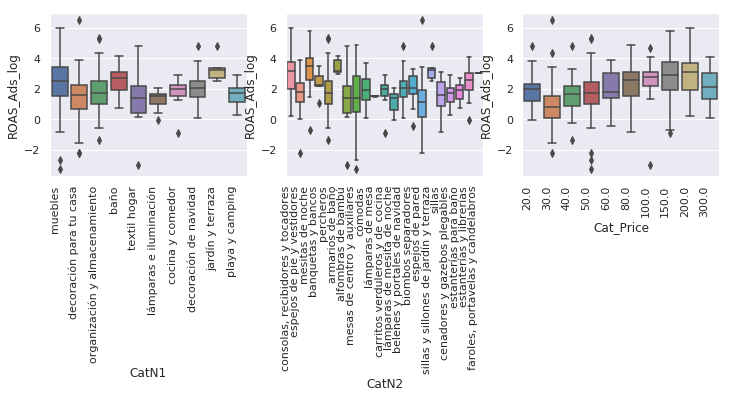

In [42]:
#select categorical columns
categorical_columns_index_log = df.dtypes[(df.dtypes == 'object') | (df.dtypes == 'category')].index

#set number of columns and rows
number_rows = 1
number_cols = 3

#establish target
y_df = 'ROAS_Ads_log'

#set parameters
li_cat_columns = list(categorical_columns_index_log)

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3), squeeze=False)

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_cat_columns):
            g = sns.boxplot(x = li_cat_columns[f], y = y_df, data = df, ax = axs[r][c])
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')

#show
plt.tight_layout()    
plt.show()

#save figure
fig.savefig('./img/distribution_categoricalfeatures_with_target.png', dpi = 180)

-----------------------------------------------------------------------------------
<a name='data_wrangling'></a>
# Data wrangling

In this whole chapter, it is transformed the data with the purpose of making it more valuable for analytical studies.

<a name='data_correlation'></a>
## Correlation

It is studied the correlation of features with the target variable

<a name='data_correlation_numerical_original'></a>
### Correlation of numerical features to target variable

It is measured the correlation of numerical features to target ROAS_log

In [43]:
#drop percentile column
df.drop('percentile', axis=1, inplace=True)

#correlations of numerical features
df.corr()['ROAS_Ads_log'].sort_values()

Cost_log                 -0.606376
Clics_log                -0.594711
Cost_1w_log              -0.510518
Clics_1w                 -0.457539
Impressions_log          -0.440912
Clics_2w                 -0.429750
Cost_2w                  -0.429559
Cost_3w                  -0.414751
Clics_3w                 -0.408563
Cost_4w                  -0.399172
Clics_4w                 -0.393763
Page_Views_1w_log        -0.377444
Impressions_1w_log       -0.372469
Page_Views_2w_log        -0.370550
Page_Views_3w_log        -0.350757
Page_Views_4w_log        -0.340702
Impressions_2w_log       -0.332849
Impressions_3w_log       -0.307852
CTR_log                  -0.304677
Page_Views_log           -0.301085
All_Conversions_4w_log   -0.297814
All_Conversions_3w_log   -0.290900
All_Conversions_2w_log   -0.270190
Conversions_4w_log       -0.254464
Conversions_3w_log       -0.252898
Impressions_4w           -0.247928
CTR_2w                   -0.228140
Conversions_2w_log       -0.220421
CTR_1w              

<a name='data_correlation_categorical_original'></a>
### Correlation of categorical features to target variable

First of all, it is applied one-hot encoding to the categorical values

In [44]:
#cat price to string
df['Cat_Price'] = df['Cat_Price'].astype(str)

#select categorical columns
df_categorical = df.select_dtypes('object')

#one-hot encoding of these columns
df_categorical = pd.get_dummies(df_categorical, prefix_sep= '_')

#append ROAS_Ads_log to dataframe
df_categorical['ROAS_Ads_log'] = df['ROAS_Ads_log']
df_categorical.head()

,CatN1_baño,CatN1_cocina y comedor,CatN1_decoración de navidad,CatN1_decoración para tu casa,CatN1_jardín y terraza,CatN1_lámparas e iluminación,CatN1_muebles,CatN1_organización y almacenamiento,CatN1_playa y camping,CatN1_textil hogar,CatN2_alfombras de bambú,CatN2_armarios de baño,CatN2_banquetas y bancos,CatN2_belenes y portales de navidad,CatN2_biombos separadores,CatN2_carritos verduleros y de cocina,CatN2_cenadores y gazebos plegables,"CatN2_consolas, recibidores y tocadores",CatN2_cómodas,CatN2_espejos de pared,CatN2_espejos de pie y vestidores,CatN2_estanterías para baño,CatN2_estanterías y librerías,"CatN2_faroles, portavelas y candelabros",CatN2_lámparas de mesa,CatN2_lámparas de mesita de noche,CatN2_mesas de centro y auxiliares,CatN2_mesitas de noche,CatN2_percheros,CatN2_sillas,CatN2_sillas y sillones de jardín y terraza,Cat_Price_100.0,Cat_Price_150.0,Cat_Price_20.0,Cat_Price_200.0,Cat_Price_30.0,Cat_Price_300.0,Cat_Price_40.0,Cat_Price_50.0,Cat_Price_60.0,Cat_Price_80.0,ROAS_Ads_log
136,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3.180551
172,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.375883
186,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.891627
203,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.751416
29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.821379


It is measured the correlation of categorical features to target ROAS_log

In [45]:
#correlation of categorical features
df_categorical.corr()['ROAS_Ads_log'].sort_values()

Cat_Price_30.0                                -0.280763
CatN2_espejos de pared                        -0.256202
CatN1_decoración para tu casa                 -0.241475
Cat_Price_50.0                                -0.110183
CatN2_sillas                                  -0.090867
CatN2_mesas de centro y auxiliares            -0.085049
Cat_Price_40.0                                -0.078301
CatN2_espejos de pie y vestidores             -0.072267
CatN1_lámparas e iluminación                  -0.065826
CatN2_lámparas de mesita de noche             -0.064418
CatN1_textil hogar                            -0.063652
CatN2_alfombras de bambú                      -0.063652
CatN1_playa y camping                         -0.037479
CatN2_cenadores y gazebos plegables           -0.037479
CatN2_percheros                               -0.034483
CatN1_organización y almacenamiento           -0.034483
Cat_Price_20.0                                -0.030907
CatN1_cocina y comedor                        -0

<a name='data_feature_selection'></a>
## Feature Selection

**Why should it be applied feature selection to this dataset?**
    - Enable to train faster the machine learning models.
    - Reduces complexity and size of the dataset.
    - Improve the key scores of the model: increase accuracy and reduce overfitting.


First of all, it is necessary to make one-hot encoding for categorical features, but in this case, applying and saving the values at the same dataframe as numerical columns.

In [46]:
#one-hot encoding of these columns
df_all = pd.get_dummies(df, prefix_sep = '_')

#columns to list
list_columns = df_all.columns.tolist()
list_columns.remove('ROAS_Ads_log')

#set X and y
X = df_all[list_columns]

y = df_all.ROAS_Ads_log

#X columns to list
feature_name = X.columns.tolist()

<a name='data_pearson'></a>
### Pearson

It is applied Pearson to select features.


In [47]:
#apply pearson function
corr_support, corr_feature = pearson_selector(feature_name, X, y)

#print result
print('The number of selected features is {}'.format(str(len(corr_feature))))

The number of selected features is 20


<a name='data_random_forest'></a>
### Random Forest

It is applied Random Forest to select features.

In [48]:
#apply random forest
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=15), threshold='3*median')

#fit
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='3*median')

In [49]:
#support
embeded_rf_support = embeded_rf_selector.get_support()

#list
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
#print(str(len(embeded_rf_feature)), 'selected features')

#print result
print('The number of selected features is {}'.format(str(len(embeded_rf_feature))))

The number of selected features is 18


<a name='data_LGBMRegressor'></a>
### LGBMRegressor

It is applied LGBMRegressor to select features.

In [50]:
#apply LGBMRegressor
lgbc= LGBMRegressor(n_estimators=30, learning_rate=0.05, num_leaves=25, colsample_bytree=0.3,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=5)

#set parameters to selector
embeded_lgb_selector = SelectFromModel(lgbc, threshold='10*median')

#fit
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=5, min_split_gain=0.01,
       n_estimators=30, n_jobs=-1, num_leaves=25, objective=None,
       random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=None, norm_order=1, prefit=False,
        threshold='10*median')

In [51]:
#support
embeded_lgb_support = embeded_lgb_selector.get_support()

#list
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

#print(str(len(embeded_lgb_feature)), 'selected features')
#print result
print('The number of selected features is {}'.format(str(len(embeded_lgb_feature))))

The number of selected features is 12


<a name='data_final_feature_selection'></a>
### Final Feature Selection

Finally, it is concatenate in a dataframe the results of previous models to make a selection.



In [52]:
#all selection in a dataframe
feature_selection = pd.DataFrame({'Feature':feature_name, 
                                  'Pearson':corr_support, 
                                  'Random Forest':embeded_rf_support, 
                                  'LightGBM':embeded_lgb_support})

#count
feature_selection['Total'] = np.sum(feature_selection, axis=1)

#print
feature_selection = feature_selection.sort_values(['Total','Feature'] , ascending=False)
feature_selection.index = range(1, len(feature_selection)+1)
feature_selection

,Feature,Pearson,Random Forest,LightGBM,Total
1,Impressions_log,True,True,True,3
2,Cost_log,True,True,True,3
3,Cost_1w_log,True,True,True,3
4,Conversions_log,True,True,True,3
5,Clics_log,True,True,True,3
6,Clics_1w,True,True,True,3
7,Ads_Income_log,True,True,True,3
8,Ads_Income_All_log,True,True,True,3
9,Impressions_1w_log,True,True,False,2
10,CPC_medio,False,True,True,2


After that, it is filter by a score equal or upper 2 to filter the selected columns

In [53]:
#filter of Total = 2 
columns_select_final = feature_selection [feature_selection['Total'] >= 2]

#select features
columns_selection = columns_select_final['Feature']

#apply to dataframe
df_final = df_all[columns_selection]

#head
df_final.head()

,Impressions_log,Cost_log,Cost_1w_log,Conversions_log,Clics_log,Clics_1w,Ads_Income_log,Ads_Income_All_log,Impressions_1w_log,CPC_medio,Ads_Income_1w_log
136,3.663562,0.029559,-1.609438,-1.832581,1.386294,0.86,3.210037,3.210037,3.603049,0.26,1.264127
172,6.111467,-0.248461,-0.494296,-1.171183,1.098612,1.43,4.127457,4.127457,5.627621,0.26,2.181547
186,6.714171,0.732368,0.832909,0.000000,1.945910,5.00,5.624018,5.624018,6.605298,0.30,3.678071
203,7.150701,0.850151,0.604316,-1.108663,1.791759,5.57,1.603420,1.603420,7.043038,0.39,-0.342490
29,8.066521,1.252763,1.373716,-1.108663,2.484907,14.50,4.074312,4.074312,8.163941,0.29,3.380995


Check the data

In [54]:
df_final.shape

(494, 11)

In [55]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 136 to 204
Data columns (total 11 columns):
Impressions_log       494 non-null float64
Cost_log              494 non-null float64
Cost_1w_log           494 non-null float64
Conversions_log       494 non-null float64
Clics_log             494 non-null float64
Clics_1w              494 non-null float64
Ads_Income_log        494 non-null float64
Ads_Income_All_log    494 non-null float64
Impressions_1w_log    494 non-null float64
CPC_medio             494 non-null float64
Ads_Income_1w_log     494 non-null float64
dtypes: float64(11)
memory usage: 56.3 KB


<a name='outliers'></a>
## Outliers

Outliers exists in our dataset because of variability of the data.

<br> In this chapter, it is analyzed the IQR values and filter outliers.

In [56]:
#introduce log
df_final['ROAS_Ads_log'] = df['ROAS_Ads_log']
df_final['ROAS_Ads_log'] = y

#index dtypes 
numerical_columns_selection = df_final.dtypes.index

#create empty dataframe
data_IQR = pd.DataFrame([])

#calculate IQR for each feature
for col in numerical_columns_selection:
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    data_IQR = data_IQR.append(pd.DataFrame({'IQR': round(Q3 - Q1,2)}, index=[0]), ignore_index=True)

Create a dataframe with index values of the columns

In [57]:
#dictionary dtypes
numerical_columns_selection_final = df_final.dtypes

#dataframe
numerical_columns_selection_final = pd.DataFrame({'Index':numerical_columns_selection_final.index, 
                                    'Values':numerical_columns_selection_final.values})   

Concatenate both dataframes to display IQR values for each feature

In [58]:
#concat dataframes
df_concat_IQR = pd.concat([numerical_columns_selection_final['Index'], data_IQR], 1)
df_concat_IQR

,Index,IQR
0,Impressions_log,1.05
1,Cost_log,1.32
2,Cost_1w_log,1.24
3,Conversions_log,0.94
4,Clics_log,1.17
5,Clics_1w,28.53
6,Ads_Income_log,1.37
7,Ads_Income_All_log,1.48
8,Impressions_1w_log,1.07
9,CPC_medio,0.13


Apply IQR filter to the dataset

In [59]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = round(Q3 - Q1,2)

df_final = df_final[~((df_final < (Q1 - 1.5 * IQR)) | (df_final > (Q3 + 1.5 * IQR))).any(axis=1)]

In [60]:
df_final.shape

(415, 12)

<a name='correlation_feature_selection'></a>
## Correlation feature selection

Measure the correlation of the selected features

In [61]:
df_final.corr()['ROAS_Ads_log'].sort_values()

Clics_log            -0.630306
Cost_log             -0.629264
Cost_1w_log          -0.547378
Clics_1w             -0.489194
Impressions_log      -0.447347
Impressions_1w_log   -0.355193
CPC_medio            -0.085838
Ads_Income_1w_log     0.310193
Conversions_log       0.348593
Ads_Income_All_log    0.614242
Ads_Income_log        0.714032
ROAS_Ads_log          1.000000
Name: ROAS_Ads_log, dtype: float64

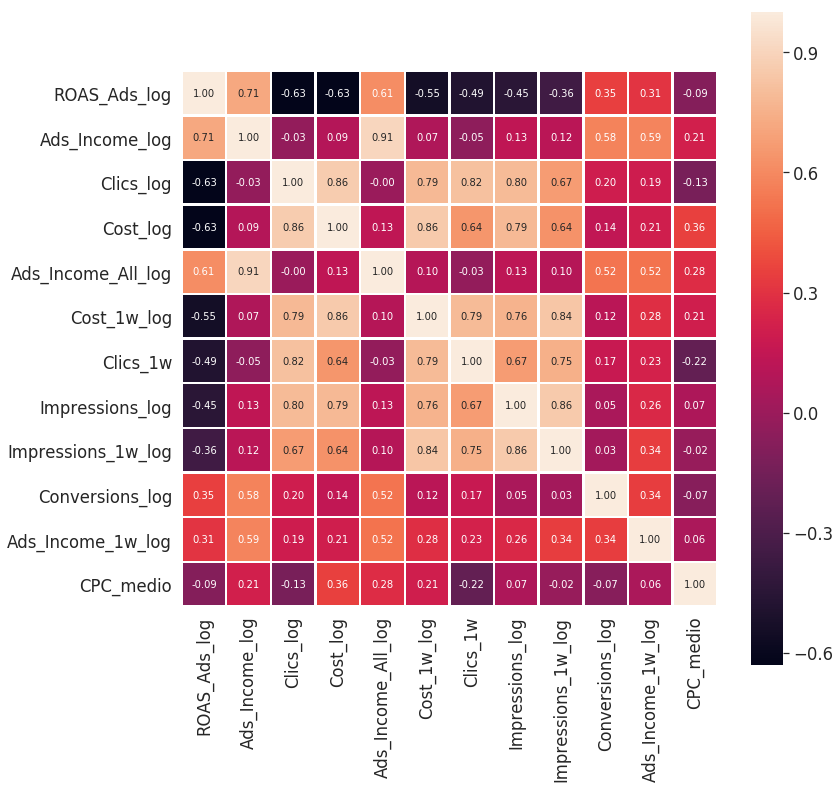

In [62]:
#length columns
number_columns = len(df_final.columns)

#heatmap
plot_correlation_heatmap(df_final, number_columns, "ROAS_Ads_log")

<a name='distribution_feature_selection'></a>
## Distribution of feature selection with target

Distribution of columns with target

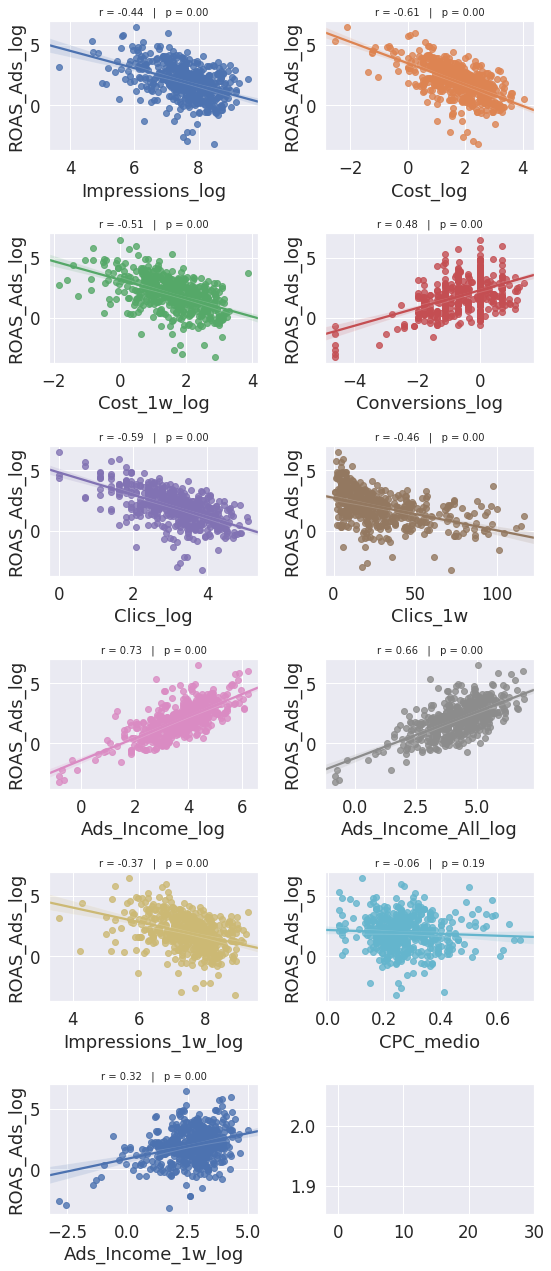

In [63]:
#select index numerical columns
columns_dtypes = df_final.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'ROAS_Ads_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_Ads_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
#show
plt.tight_layout()    
plt.show()

<a name='multicollinearity'></a>
## Multicollinearity

It is measured the multicollinearity between different features to improve accuracy of the regression models.

In [64]:
#save correlation
corr_final = df_final.corr()['ROAS_Ads_log'].sort_values()

#correlation to dataframe
df_corr_final = pd.DataFrame({'Index':corr_final.index, 'Values':abs(corr_final.values)}) 
df_corr_final

#split the index
#df_corr_final[['First', 'Second', 'Third', 'Fourth', 'Fifth']] = df_corr_final['Index'].str.rsplit("_", n = 4, expand=True)
try:
    df_corr_final[['First', 'Second', 'Third', 'Fourth', 'Fift']] = df_corr_final['Index'].str.rsplit("_", 
                                                                                                      n = 4, 
                                                                                                      expand=True)
except:
    df_corr_final[['First', 'Second', 'Third', 'Fourth']] = df_corr_final['Index'].str.rsplit("_", 
                                                                                              n = 3, 
                                                                                              expand=True)

#sort values
df_corr_final = df_corr_final.sort_values(by = 'Values', ascending = False)

#groupby
df_groupby = df_corr_final.groupby('First').first()


#select column
columns_groupby = ['First', 'Index', 'Values']

#display
df_groupby.reset_index(inplace = True)
df_groupby = df_groupby[columns_groupby]


#apply prove function to filter again by similar features defintions
df_groupby['NEW'] = df_groupby.apply(lambda x: prove(x, 'First'), axis=1)

#groupby by the most important value of each group
df_groupby = df_groupby.groupby('NEW').first()

#display
df_groupby

,First,Index,Values
NEW,,,
CPC_medio,CPC,CPC_medio,0.085838
Clic_Imp_CTR,Clics,Clics_log,0.630306
Conversions,Conversions,Conversions_log,0.348593
Cost_Inc,Ads,Ads_Income_log,0.714032
ROAS,ROAS,ROAS_Ads_log,1.000000


This are the final columns

In [65]:
#save features selected as columns
df_columns_list = df_groupby.Index.values.tolist()

#select columns
df_columns_list

#save data
df_all = df_final[df_columns_list]

Check dataset

In [66]:
df_all.head()

,CPC_medio,Clics_log,Conversions_log,Ads_Income_log,ROAS_Ads_log
172,0.26,1.098612,-1.171183,4.127457,4.375883
186,0.30,1.945910,0.000000,5.624018,4.891627
29,0.29,2.484907,-1.108663,4.074312,2.821379
34,0.24,3.258097,0.000000,5.087596,3.250374
42,0.22,2.564949,-1.966113,3.141563,2.094330


In [67]:
df_all.shape

(415, 5)

In [68]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 172 to 204
Data columns (total 5 columns):
CPC_medio          415 non-null float64
Clics_log          415 non-null float64
Conversions_log    415 non-null float64
Ads_Income_log     415 non-null float64
ROAS_Ads_log       415 non-null float64
dtypes: float64(5)
memory usage: 19.5 KB


It is calculated the VIF

In [69]:
#df_test = df_all
df_test = df_all.drop(['ROAS_Ads_log'], axis=1)

#vif
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df_test.values, i) for i in range(df_test.shape[1])]
vif['features'] = df_test.columns

In [70]:
vif.round(1)

,VIF Factor,features
0,10.1,CPC_medio
1,10.3,Clics_log
2,1.5,Conversions_log
3,15.8,Ads_Income_log


These values are right to avoid multicollinearity (Hair et al., 1995)

<a name='standardscaler'></a>
## StandardScaler

**¿Why standarized the dataset?**
<br> It implies to change the range of values so that the distribution standard deviation from the mean equals one. 

In [71]:
#apply standardscaler
sc = StandardScaler()
df_all_sc = sc.fit_transform(df_all)

#final dataset
df_all_sc = pd.DataFrame(df_all_sc)

#rename columns
df_all_sc.columns = df_columns_list

Check the data

In [72]:
df_all_sc.head(5)

,CPC_medio,Clics_log,Conversions_log,Ads_Income_log,ROAS_Ads_log
0,-0.044004,-2.701817,-1.117805,0.350541,2.013922
1,0.396034,-1.596823,0.509708,2.006135,2.459338
2,0.286025,-0.893897,-1.030925,0.291748,0.671390
3,-0.264023,0.114450,0.509708,1.412711,1.041888
4,-0.484042,-0.789510,-2.222465,-0.740121,0.043482


In [73]:
df_all_sc.shape

(415, 5)

In [74]:
df_all_sc.describe()

,CPC_medio,Clics_log,Conversions_log,Ads_Income_log,ROAS_Ads_log
count,4.150000e+02,415.000000,415.000000,4.150000e+02,4.150000e+02
mean,-9.951879e-17,0.000000,0.000000,1.155702e-16,3.253087e-16
std,1.001207e+00,1.001207,1.001207,1.001207e+00,1.001207e+00
min,-2.464213e+00,-2.701817,-2.222465,-3.015017e+00,-2.250732e+00
25%,-7.040608e-01,-0.692863,-0.481875,-6.917862e-01,-6.650249e-01
50%,-4.400380e-02,0.010063,0.509708,4.046266e-02,-2.052019e-02
75%,6.160532e-01,0.739880,0.509708,7.609856e-01,7.063949e-01
max,2.816243e+00,2.524302,2.436146,2.652828e+00,2.768725e+00


<a name='grade_percentile_target'></a>
## Grade Percentile of target variable

Calculate the grade percentile of target variable

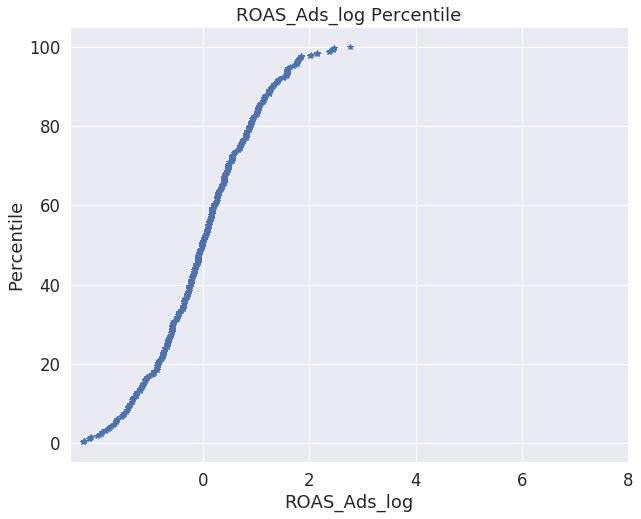

In [88]:
#create percentile
df_all_sc['percentile'] = df_all_sc['ROAS_Ads_log'].apply(lambda x: percentileofscore(df_all_sc['ROAS_Ads_log'], x))

# plot percentile
#set size
x = plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df_all_sc['ROAS_Ads_log'], df_all_sc['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS_Ads_log')
plt.ylabel('Percentile')
plt.title('ROAS_Ads_log Percentile');

#save figure
x.savefig('./img/ROAS_Ads_log_Percentile_after_wrangling', dpi = 180)

In [89]:
print('50th percentile: {}'.format(round(np.min(df_all_sc.loc[df_all_sc['percentile'] > 50, 'ROAS_Ads_log']),2)))
print('90th percentile: {}'.format(round(np.min(df_all_sc.loc[df_all_sc['percentile'] > 90, 'ROAS_Ads_log']),2)))

50th percentile: -0.02
90th percentile: 1.31


<a name='distribution_final_dataset'></a>
## Correlation and Distribution final dataset

Correlation and distribution of the final selected features with the target

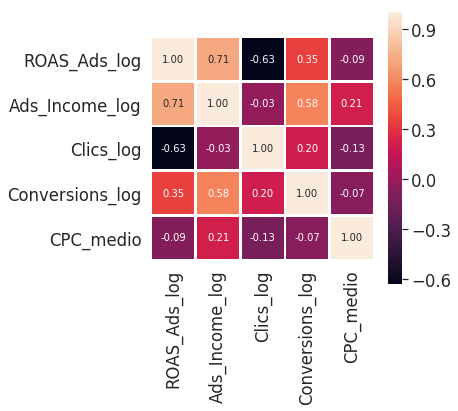

In [90]:
#remove percentile feature
df_all_sc.drop('percentile', axis=1, inplace=True)

#length columns
number_columns = len(df_all_sc.columns)

#heatmap
plot_correlation_heatmap(df_all_sc, number_columns, "ROAS_Ads_log")

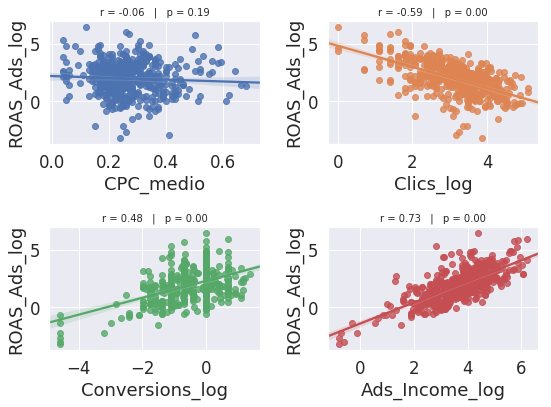

In [91]:
#select index numerical columns
columns_dtypes = df_all_sc.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'ROAS_Ads_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_Ads_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
          
    
#show
plt.tight_layout()    
plt.show()

#save
fig.savefig('./img/distribution_final_features_after_wrangling', dpi = 180)

<a name='regression_models'></a>
# Regression Models

It is analyzed all the data selected with regression models:
    - LinearRegression
    - KNN Regressor
    - Ridge
    - Lasso
    - Elastic Net
    - SGDRegressor
    - Gradient Boosting Descent
    - Decision Tree Regressor
    - Random Forest Regressor
    
The selected scores to measure the results are:
    - MAE
    - RMSE
    - R_squared

<a name='data_models'></a>
## Data for models
Select data for the regression models

In [92]:
#to list
df_regression_columns = df_all_sc.columns.tolist()

#create X variable
X = df_all_sc[df_regression_columns]

#drop ROAS_Ads from X
#remove percentile feature
X.drop('ROAS_Ads_log', axis=1, inplace=True)


#create y variable
y = df_all_sc['ROAS_Ads_log']

In [93]:
X.head()

,CPC_medio,Clics_log,Conversions_log,Ads_Income_log
0,-0.044004,-2.701817,-1.117805,0.350541
1,0.396034,-1.596823,0.509708,2.006135
2,0.286025,-0.893897,-1.030925,0.291748
3,-0.264023,0.114450,0.509708,1.412711
4,-0.484042,-0.789510,-2.222465,-0.740121


Target variable

In [94]:
y.head()

0    2.013922
1    2.459338
2    0.671390
3    1.041888
4    0.043482
Name: ROAS_Ads_log, dtype: float64

In [95]:
y.describe()

count    4.150000e+02
mean     3.253087e-16
std      1.001207e+00
min     -2.250732e+00
25%     -6.650249e-01
50%     -2.052019e-02
75%      7.063949e-01
max      2.768725e+00
Name: ROAS_Ads_log, dtype: float64

<a name='application_models'></a>
## Model application
Apply models to the dataset

Name scores

In [96]:
score_calc = 'neg_mean_squared_error'
scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'rsquared':'r2'}

<a name='knn'></a>
### KNeighbors Regressor

It is applied KNeighbors Regressor

In [97]:
#apply grid search
reg_knn_gs = GridSearchCV(KNeighborsRegressor(),
            param_grid = {"n_neighbors":np.arange(4,100)},
            cv = nr_cv,
            scoring = score_calc)
    
#fit
reg_knn_gs.fit(X,y)
    
#get best params
knn_best_params = reg_knn_gs.best_params_.get('n_neighbors')
    
#apply knn to best params
reg_knn = KNeighborsRegressor(n_neighbors = knn_best_params)
    
#cross validation
scores = cross_validate(reg_knn, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)
    
#saves scores
knn_mae = abs(scores['test_abs_error'].mean())
knn_rmse = math.sqrt(abs(scores['test_squared_error'].mean()))
knn_r2 = abs(scores['test_rsquared'].mean())

<a name='mlr'></a>
### Linear Regression

It is applied Linear Regression

In [98]:
#apply linear regression with grid search
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = nr_cv, verbose = 1 , scoring = score_calc)

#fit
grid_linear.fit(X, y)

#get best params
#mlr_best_params = grid_linear.best_params_

#aply linear regression with best params
reg_mlr = LinearRegression(grid_linear.best_params_)

#cross validation
scores_mlr = cross_validate(reg_mlr, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
mlr_mae = abs(scores_mlr['test_abs_error'].mean())
mlr_rmse = math.sqrt(abs(scores_mlr['test_squared_error'].mean()))
mlr_r2 = abs(scores_mlr['test_rsquared'].mean())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


<a name='ridge'></a>
### Ridge

It is applied Ridge

In [99]:
#apply ridge with grid search 
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv= nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_ridge.fit(X, y)

#save best params values as list
ridge_best_params_list = list(grid_ridge.best_params_.values())

##apply ridge with best params
ridge_best_params = Ridge(alpha = ridge_best_params_list[0], 
                          normalize = ridge_best_params_list[1], 
                          tol= ridge_best_params_list[2])

#cross validation
scores_ridge = cross_validate(ridge_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
ridge_mae = abs(scores_ridge['test_abs_error'].mean())
ridge_rmse = math.sqrt(abs(scores_ridge['test_squared_error'].mean()))
ridge_r2 = abs(scores_ridge['test_rsquared'].mean())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.0s finished


<a name='lasso'></a>
### Lasso

It is applied Lasso

In [100]:
#apply lasso with grid search
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 
              'normalize':[True,False], 
              'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1, scoring = score_calc)

#fit
grid_lasso.fit(X, y)

#save best params values as list
lasso_best_params_list = list(grid_lasso.best_params_.values())

#apply lasso with best params
reg_lasso = Lasso(alpha= lasso_best_params_list[0], 
                  normalize= lasso_best_params_list[1],
                  tol= lasso_best_params_list[2])

#cross validation
scores_lasso = cross_validate(reg_lasso, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
lasso_mae = abs(scores_lasso['test_abs_error'].mean())
lasso_rmse = math.sqrt(abs(scores_lasso['test_squared_error'].mean()))
lasso_r2 = abs(scores_lasso['test_rsquared'].mean())

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.8s finished


<a name='enet'></a>
### Elastic Net

It is applied Elastic Net

In [101]:
#apply elastic net with grid search 
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv = nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_enet.fit(X, y)

#save best params as list
enet_best_params_list = list(grid_enet.best_params_.values())


#apply enet with best params
enet_best_params = ElasticNet(alpha = enet_best_params_list[0], 
                              fit_intercept= enet_best_params_list[1], 
                              l1_ratio= enet_best_params_list[2], 
                              max_iter= enet_best_params_list[3], 
                              normalize= enet_best_params_list[4],
                              tol= enet_best_params_list[5])

#cross validation
scores_enet = cross_validate(enet_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
enet_mae = abs(scores_enet['test_abs_error'].mean())
enet_rmse = math.sqrt(abs(scores_enet['test_squared_error'].mean()))
enet_r2 = abs(scores_enet['test_rsquared'].mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.6s finished


<a name='sgd'></a>
### SGD Regressor

It is applied SGD Regressor

In [102]:
#apply sgd regressor with grid search
sgd = SGDRegressor()
parameters = {'max_iter' :[1000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]}
grid_sgd = GridSearchCV(sgd, parameters, cv = nr_cv, verbose = 1, scoring = score_calc)

#fit
grid_sgd.fit(X, y)

#save best params values as list
sgd_best_params_list = list(grid_sgd.best_params_.values())

#apply best params to sgd
sgd = SGDRegressor(alpha = sgd_best_params_list[0], 
                   epsilon = sgd_best_params_list[1], 
                   fit_intercept = sgd_best_params_list[2], 
                   max_iter = sgd_best_params_list[3])

#cross validation
scores_sgd = cross_validate(sgd, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
sgd_mae = abs(scores_sgd['test_abs_error'].mean())
sgd_rmse = math.sqrt(abs(scores_sgd['test_squared_error'].mean()))
sgd_r2 = abs(scores_sgd['test_rsquared'].mean())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


<a name='dtr'></a>
### Decision Tree Regressor

It is applied Decision Tree Regressor

In [103]:
#apply decision tree with grid search
reg_dtr = GridSearchCV(DecisionTreeRegressor(),
                  param_grid = {"max_depth":np.arange(2,8),
                              "min_samples_leaf":[10,30,50,100]},
                  cv = nr_cv,
                  scoring = "neg_mean_absolute_error")

#fit
reg_dtr.fit(X,y)

#save best params values as a list
dtr_best_params = list(reg_dtr.best_params_.values())

#apply decision tree with best params
reg_dtr = DecisionTreeRegressor(max_depth = dtr_best_params[0], min_samples_leaf = dtr_best_params[1])

#cross validation
scores_dtr = cross_validate(reg_dtr, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#saves scores
dtr_mae = abs(scores_dtr['test_abs_error'].mean())
dtr_rmse = math.sqrt(abs(scores_dtr['test_squared_error'].mean()))
dtr_r2 = abs(scores_dtr['test_rsquared'].mean())

<a name='gbr'></a>
### Gradient Boosting Regressor

It is applied Gradient Boosting Regressor

In [104]:
#apply gradient boosting regressor with gird search
reg_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators = nr_est),
                  param_grid = {"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring = "neg_mean_absolute_error",
                  cv = nr_cv)

#fit
reg_gbr.fit(X,y)

#save best params values as list
gbr_best_params_list = list(reg_gbr.best_params_.values())

#apply gradient boosting regressor with best params
gbr_best_params = GradientBoostingRegressor(max_depth = gbr_best_params_list[1], 
                                            n_estimators= nr_est,
                                            learning_rate = gbr_best_params_list[0])

#cross validation
scores_gbr = cross_validate(gbr_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

#saves scores
gbr_mae = abs(scores_gbr['test_abs_error'].mean())
gbr_rmse = math.sqrt(abs(scores_gbr['test_squared_error'].mean()))
gbr_r2 = abs(scores_gbr['test_rsquared'].mean())

<a name='rfr'></a>
### Random Forest Regressor

It is applied Random Forest Regressor

In [105]:
#apply random forest regressor with grid search
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [20,50], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)

#fit
grid_rf.fit(X, y)

#save best params values as list
rfr_best_params_list = list(grid_rf.best_params_.values())

#apply random forest regressor with best params
rfr_best_params = RandomForestRegressor(min_samples_split = rfr_best_params_list[0], 
                                        n_estimators = rfr_best_params_list[1], 
                                        random_state = rfr_best_params_list[2])

#cross validation
scores_rfr = cross_validate(rfr_best_params, X, y, cv = nr_cv, scoring = scoring, return_train_score = True)

#save scores
rfr_mae = abs(scores_rfr['test_abs_error'].mean())
rfr_rmse = math.sqrt(abs(scores_rfr['test_squared_error'].mean()))
rfr_r2 = abs(scores_rfr['test_rsquared'].mean())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.4s finished


<a name='comparison'></a>
## Regression Models Results

Display the final results

In [106]:
#list mae
list_mae = [knn_mae, mlr_mae, dtr_mae, gbr_mae,lasso_mae, ridge_mae, enet_mae, sgd_mae, rfr_mae]

#list rmse
list_rmse = [knn_rmse, mlr_rmse, dtr_rmse, gbr_rmse,lasso_rmse, ridge_rmse, enet_rmse,sgd_rmse,rfr_rmse]

#list r squared
list_r2 = [knn_r2, mlr_r2, dtr_r2, gbr_r2,lasso_r2, ridge_r2, enet_r2,sgd_r2,rfr_r2]

#define regressors
list_regressors = ['KNN Regressor','Linear Regression', 'Ridge', 'Lasso', 'ElaNet', 'SGD Regressor', 
                   'DecisionTree Regressor', 'GradientBoosting Regressor', 'RandomForest']

Plot results

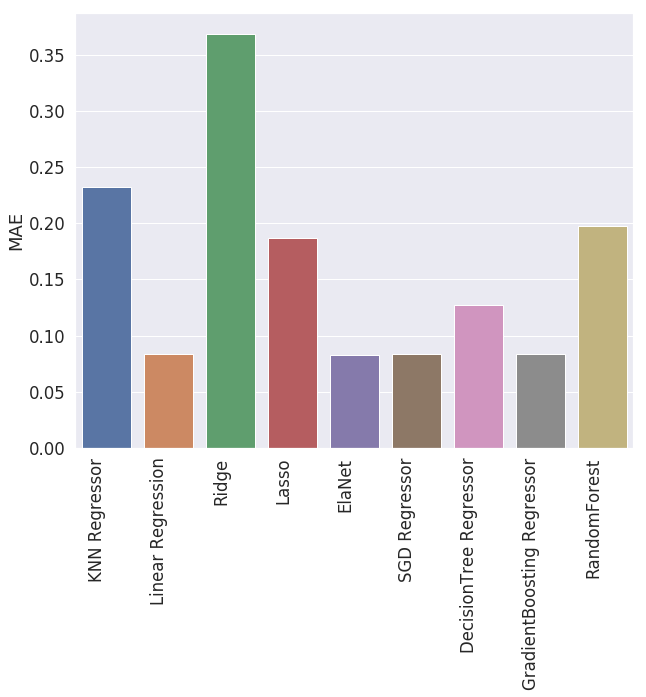

In [107]:
#plot mae 
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
mae_plot = sns.barplot(x = list_regressors, y = list_mae, ax = ax)
mae_plot.set_xticklabels(mae_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('MAE')

#plot
plt.show()

#save figure
fig.savefig('./img/MAE', dpi = 180)

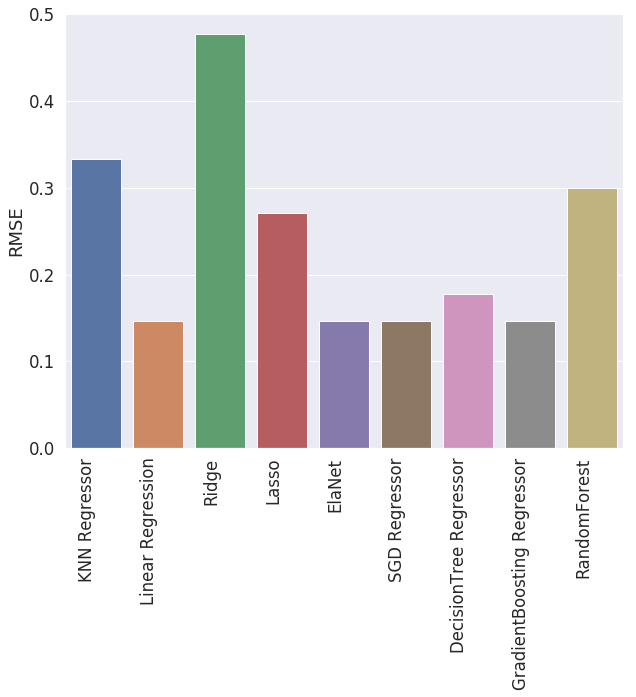

In [108]:
#plot rmse 
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
rmse_plot = sns.barplot(x = list_regressors, y = list_rmse, ax = ax)
rmse_plot.set_xticklabels(rmse_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('RMSE')

#plot
plt.show()

#save figure
fig.savefig('./img/RMSE', dpi = 180)

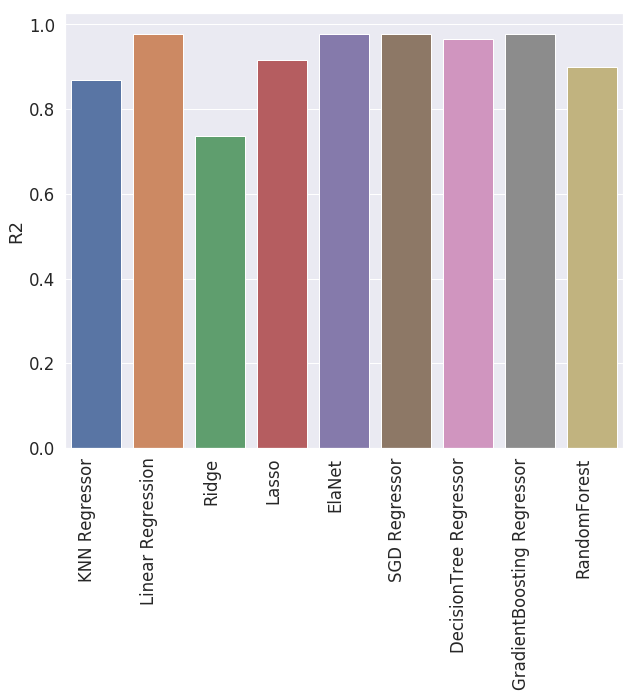

In [109]:
#plot r squared
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
r2_plot = sns.barplot(x = list_regressors, y = list_r2, ax = ax)
r2_plot.set_xticklabels(r2_plot.get_xticklabels(), rotation = 90, ha='right')
plt.ylabel('R2')

#plot
plt.show()

#save figure
fig.savefig('./img/R2', dpi = 180)

Display scores in a table

In [110]:
df_scores = pd.DataFrame(
    {'Index': list_regressors,
     'MAE': list_mae,
     'RMSE': list_rmse,
     'R2': list_r2
    })

df_scores['MAE'] = df_scores['MAE'].apply(lambda x: round(x,3))
df_scores['RMSE'] = df_scores['RMSE'].apply(lambda x: round(x,3))
df_scores['R2'] = df_scores['R2'].apply(lambda x: round(x,3))

df_scores.set_index('Index')

,MAE,RMSE,R2
Index,,,
KNN Regressor,0.233,0.333,0.869
Linear Regression,0.083,0.147,0.978
Ridge,0.368,0.477,0.737
Lasso,0.186,0.271,0.917
ElaNet,0.083,0.147,0.978
SGD Regressor,0.083,0.147,0.978
DecisionTree Regressor,0.127,0.177,0.966
GradientBoosting Regressor,0.083,0.147,0.978
RandomForest,0.198,0.300,0.899


<a name='feature_importance'></a>
## Feature importance
It is analyzed the feature importance of the features

In [111]:
rfr_best_params.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

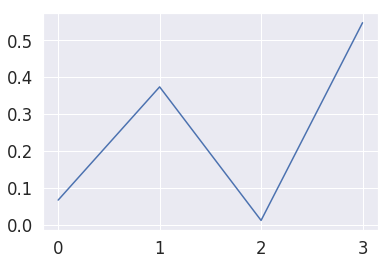

In [112]:
plt.plot(rfr_best_params.feature_importances_)

**¿Which features have a contribution higher to 10% to the model explanation?**

In [125]:
X.columns[rfr_best_params.feature_importances_>0.1]

Index(['Clics_log', 'Ads_Income_log'], dtype='object')

Sort feature importance from highest to lowest

In [132]:
#create a dataframe
df_feature_importance = pd.DataFrame.from_dict(zip(X.columns, rfr_best_params.feature_importances_))

#rename columns
df_columns_list_final = ['Feature', 'Importance']
df_feature_importance.columns = df_columns_list_final

#round values
df_feature_importance['Importance'] = round(df_feature_importance['Importance'],2)

#sort values
df_feature_importance = df_feature_importance.sort_values(by = 'Importance', ascending = False)

#show
df_feature_importance

,Feature,Importance
3,Ads_Income_log,0.55
1,Clics_log,0.37
0,CPC_medio,0.07
2,Conversions_log,0.01


**In the previous table, it is possible to check the importance of each feature in the optimization of shopping advertisment.**

**The first two features are the most relevant for the regression model. For this reason, these have to concentrate the resources in order to analyze and improve profitability of the campaigns.**